In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random

In [5]:
def load_data(image_size, labels, base_path):
    X = []
    Y = []
    for label in labels:
        folderPath = os.path.join(base_path, label)
        for img_name in os.listdir(folderPath):
            img_path = os.path.join(folderPath, img_name)
            try:
              img = cv2.imread(img_path)
              img = cv2.resize(img, (image_size, image_size))
              X.append(img)
              Y.append(labels.index(label))
            except Exception as e:
              print(f"Error loading {img_name}: {e}")
    return X, Y
    # return np.array(X), np.array(Y)

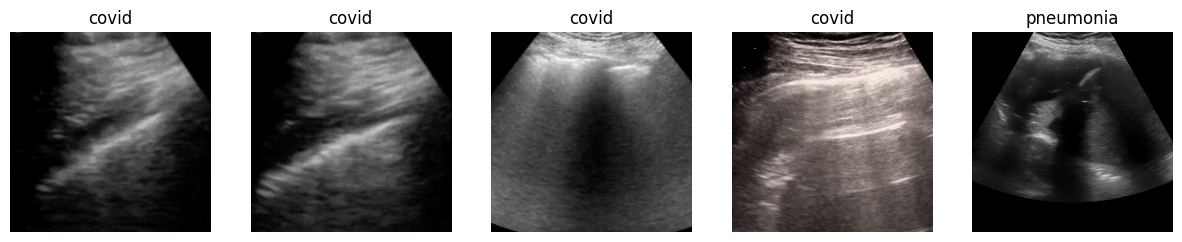

In [6]:
def display_random_images(X, Y, labels, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        idx = random.randint(0, len(X) - 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[idx])
        plt.title(labels[Y[idx]])
        plt.axis('off')
    plt.show()

# Example usage
labels = ['covid', 'pneumonia']
base_path = '/content/drive/MyDrive/covid_pneumonia'  # Replace with your dataset path
image_size = 224

X, Y = load_data(image_size, labels, base_path)
display_random_images(X, Y, labels, num_images=5)

In [8]:
X = np.array(X, dtype='float32') / 255.0  # Normalize pixel values (0-1)
Y = np.array(Y)

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen.fit(X_train)

In [13]:
def build_and_train_model(base_model, X_train, Y_train, X_test, Y_test, labels, model_name):
    # Ensure GPU usage
    device_name = tf.test.gpu_device_name()
    if device_name:
        print(f"✅ Training on GPU: {device_name}")
    else:
        print("❌ No GPU detected, training on CPU.")

    # Convert data to TensorFlow Dataset format for efficiency
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)) \
                    .batch(32).prefetch(tf.data.AUTOTUNE)

    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)) \
                   .batch(32).prefetch(tf.data.AUTOTUNE)

    # Freeze ResNet50 base model
    base_model.trainable = False

    # Build model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Start training
    start_time = time.time()

    history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=test_dataset
    )

    training_time = time.time() - start_time

    # Plot training history
    plt.figure(figsize=(14, 7))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Save trained model
    model.save(f'lungultrasound_model_{model_name}.h5')

    # Generate predictions
    Y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

    # Confusion Matrix and Classification Report
    conf_matrix = confusion_matrix(Y_test, Y_pred)
    class_report = classification_report(Y_test, Y_pred, target_names=labels)

    print(f'Classification Report for {model_name}:')
    print(class_report)

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Evaluate test loss and accuracy
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Calculate test error as (1 - test_accuracy)
    test_error = 1 - test_accuracy
    print(f"Test Error: {test_error:.4f}")

    return history, training_time, conf_matrix, class_report, Y_test, Y_pred


In [1]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


✅ Training on GPU: /device:GPU:0
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 399ms/step - accuracy: 0.4979 - loss: 2.2750 - val_accuracy: 0.5455 - val_loss: 0.7502
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.5910 - loss: 0.6675 - val_accuracy: 0.5657 - val_loss: 0.5888
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.7204 - loss: 0.5348 - val_accuracy: 0.9192 - val_loss: 0.4806
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8587 - loss: 0.4486 - val_accuracy: 0.9293 - val_loss: 0.4351
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.8736 - loss: 0.4087 - val_accuracy: 0.9495 - val_loss: 0.3956
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.8912 - loss: 0.3743 - val_accuracy: 0.9495 - val_loss: 0.3621
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.9016 - loss: 0.3454 - val_accuracy: 0.9495 - val_loss: 0.3335
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9169 - los

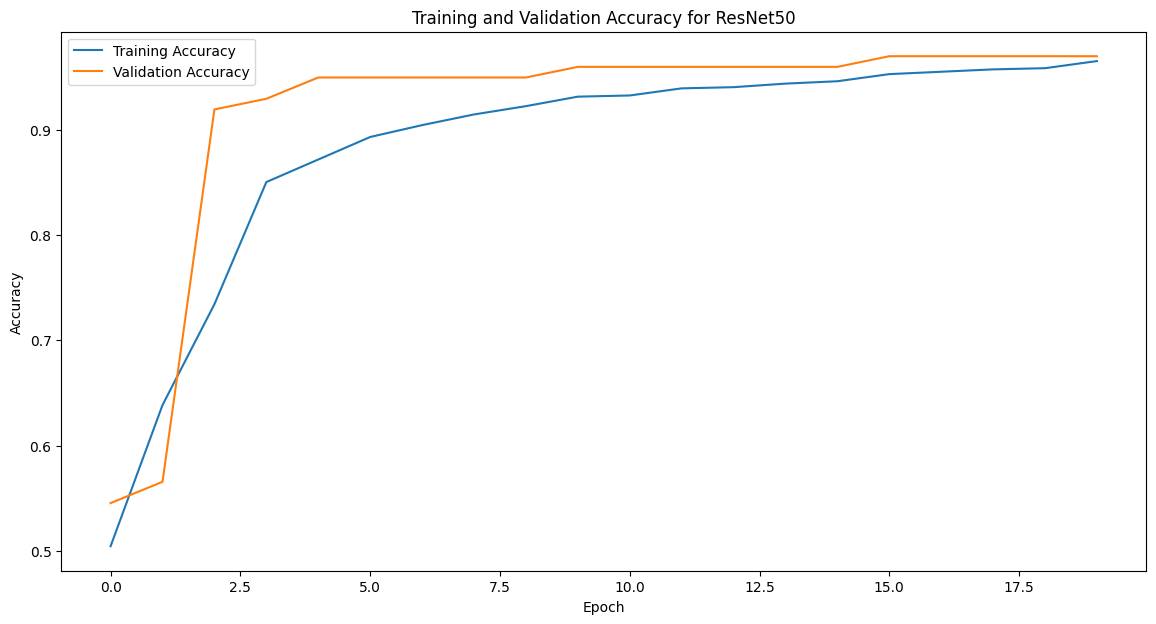

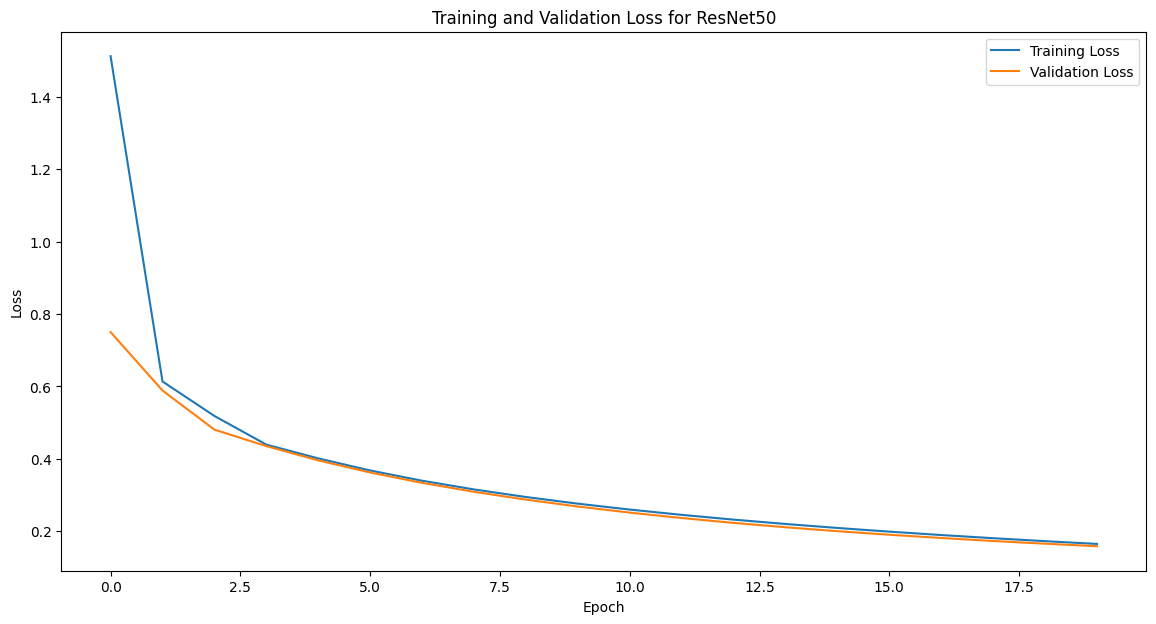

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
Classification Report for ResNet50:
              precision    recall  f1-score   support

       covid       0.96      0.98      0.97        54
   pneumonia       0.98      0.96      0.97        45

    accuracy                           0.97        99
   macro avg       0.97      0.97      0.97        99
weighted avg       0.97      0.97      0.97        99



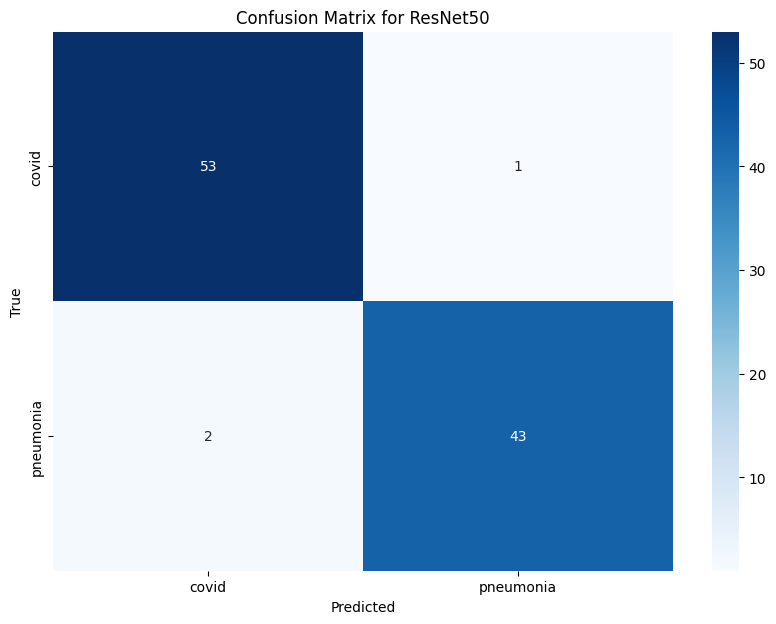

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9837 - loss: 0.1536 
Test Loss: 0.1584
Test Accuracy: 0.9697
Test Error: 0.0303


In [14]:
# Load ResNet50 base model
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Train model (assuming build_and_train_model is defined)
history_resnet, time_resnet, conf_matrix_resnet, report_resnet, Y_test_resnet, Y_pred_resnet = build_and_train_model(
    base_model_resnet, X_train, Y_train, X_test, Y_test, labels, 'ResNet50'
)
